<h1 style='text-align: center;'> 
Physical Informed Neural Networks (PINNs)
</h1>

`Narváez J.`
<p style='text-align: justify;'>

<p style='text-align: justify;'>  
In this notebook we will present the idea of Physical Informed Neural Networks (PINNs). We will create simple examples about how it works for solving ODES. </p>

# Solving ODES with PINNs

<p style='text-align: justify;'>  
The proccess of solving a diferential equation with a newral network using the ODE itself to define the cost function is known as <b> physical-informed neural network </b>.
</p>

Let's consider the next general ODE:

<div id="ODE"></div>

$$
\begin{equation} \label{ODE} \tag{1}
 f(x, u(x), u^\prime(x), u^{\prime\prime}(x), \cdots, u^{(n)}(x))=0 \hspace{0.5cm}\text{for } x\in D,
\end{equation}
$$

<p style='text-align: justify;'> 
subject to some Boundary Conditions in $\partial D$. Here, $u(x)$ is the function to be computed in its domain $D$. Now, we chose a trial solution $\Psi(x)$ such that by construction it satisfied the boundary condition, as follow,
</p>

<div id="Trial"></div>

$$
\begin{equation} \label{Trial} \tag{2}
 \Psi(x, w) = A(x) + F(x, NN(x, w)),
\end{equation}
$$

<p style='text-align: justify;'> 
where $NN(x, w)$ is a single-output neural network with weights and biases represented by $w$, F is some function which involves the neuron network and $A(x)$ contains no adjustable parameters that sotisfied the boundary conditions. In this way, $F$ is constructed such that it doesn't contribuite to the BCs.
</p>

<p style='text-align: justify;'> 
If $\Psi(x)$ was the exact solution, then it has to satisfy the condition:
</p>

<div id="PsiReq"></div>

$$
\begin{equation} \label{PsiReq} \tag{3}
 f(x, \Psi(x), \Psi^\prime(x), \Psi^{\prime\prime}(x), \cdots, \Psi^{(n)}(x))=0 \hspace{0.5cm}\text{for all} x\in D,
\end{equation}
$$

Thus,let turn this condition to our cost function. This is,

<div id="CostF"></div>

$$
\begin{equation} \label{CostF} \tag{4}
 C(w, b) = \frac{1}{2} \sum_{x \in D} f(x, \Psi(x), \Psi^\prime(x), \Psi^{\prime\prime}(x), \cdots, \Psi^{(n)}(x)),
\end{equation}
$$

## Dirichlet's Boundary Conditions

## Example 1

Let's solve the next system of ordinary diferential equations:

<div id="ODEsystem"></div>

$$
\begin{equation} \label{ODESystem} \tag{5}
  u^\prime (t)= f(u,t), 
\end{equation}
$$

with $t \in T$ and a known initial condition $u(0) = u_0$. As we saw above, we approximate the solution for the trial solution ([2](#Trial)), in this case, it takes the next form:

<div id="TrialExample"></div>

$$
\begin{equation} \label{TrialExample} \tag{6}
  \Psi(t, w)= u_0 + t \cdot NN(t, w), 
\end{equation}
$$

then, it follows the BCs inmediatly. Replacing ([6](#TrialExample)) and ([5](#ODEsystem)) in ([4](#CostF)) we get

<div id="CostExample"></div>

$$
\begin{equation} \label{CostExample} \tag{7}
  C(w, w)= \frac{1}{2}\sum_i \left(\Psi^\prime(t_i)-f(\Psi^\prime(t_i), t_i)\right)^2.
\end{equation}
$$

The choice of $t_i$ could be done in many ways: it can be random, it can be a grid, etc.

<p style='text-align: justify;'> 
From the above equation we see that when we take the gradient of C respect to parameters: weights and biases, $\nabla_w$, then we don't calculate only partial derivatives respect to $w$, but total derivatives respect to inputs $t$. And it could be complicated and expensive. For this task, we will use libraries that calculate this of a eficienty way.
</p>

Now, let's consider the case $f(u, t) = \cos{(2\pi t)}$ with $T=[0, 1]$ and the initial condition $u_0 = 1$.

We will implement the code using the library $\texttt{Flux}$. You can find more information about this tool [here](https://fluxml.ai/Flux.jl/stable/).

In [1]:
using Distributions
using Flux
using LaTeXStrings
using LinearAlgebra
using Plots
using Statistics

In [2]:
# We define a NN with: 1 input layer, 2 hidden layers and 1 output layer
NNODE = Chain(x -> [x], # Take in a scalar and transform it into an array
            Dense(1, 32, tanh), # It uses the hyperbolic tangent as activation function
            Dense(32,1), first) # Take first value, i.e. return a scalar
NNODE(1.0)

-0.17193514908055968

In [3]:
u0 = 1. # Initial condition
T = 0:1f-2:1f0 # Domain of solution V
ϵ = sqrt(eps(Float32)); # Parameter Δx for diferentiation

In [4]:
Ψ(t; NN, u0) = t*NN(t) + u0 # Trial solution

Ψ (generic function with 1 method)

In [5]:
Ψ1(t) = Ψ(t; NN=NNODE, u0 = u0)

Ψ1 (generic function with 1 method)

To calculate the derivative of $\Psi$ respect to inputs, we approximate this by the central discrete derivative, i.e., 

<div id="CentralDer"></div>

$$
\begin{equation} \label{CentralDer} \tag{8}
  u^\prime (t)= \frac{u(t+\Delta t)-u(t-\Delta t)}{2\Delta t}, 
\end{equation}
$$

in our case, we take $\Delta t = \sqrt{\epsilon}$ where $\epsilon$ is the machine presition of the floating point of type $\texttt{Float32}$.

In [6]:
loss1() = 0.5*mean(abs2(((Ψ1(t+ϵ)-Ψ1(t-ϵ))/(2*ϵ)) - cos(2π*t)) for t in T) # Loss function

loss1 (generic function with 1 method)

In [7]:
lr = 0.01 # learning rate
it = 5000 # Number of iterations

5000

In [8]:
opt = Flux.Adam(1e-3) # Classic gradient descent optimiser with learning rate lr
data = Iterators.repeated((), it) # Iterations
iter = 0
history1 = zeros(it)
cb = function () #callback function to observe training
    global iter += 1
    global history1
    history1[iter]= loss1()
    if iter % 500 == 0
        display(iter)
        display(history1[iter])
    end
end
display(loss1())

0.2722387235805422

In [9]:
Flux.train!(loss1, Flux.params(NNODE), data, opt; cb=cb)

500

0.14157742337019383

1000

0.011952973849603166

1500

0.010981138695818564

2000

0.009329412613519454

2500

0.0007846972712460008

3000

7.779118118757089e-5

3500

5.9159890012043164e-5

4000

4.68398974117276e-5

4500

3.787492012496512e-5

5000

3.019928922338126e-5

The analytical solution to last problem is given by:

<div id="AnSol1"></div>

$$
\begin{equation} \label{AnSOl1} \tag{9}
  u^\prime (t)= u_0 + \frac{1}{2\pi} \sin{(2\pi t)}.
\end{equation}
$$

In [10]:
F_target1(t) = 1.0 + sin(2π*t)/2π # Analytical solution

F_target1 (generic function with 1 method)

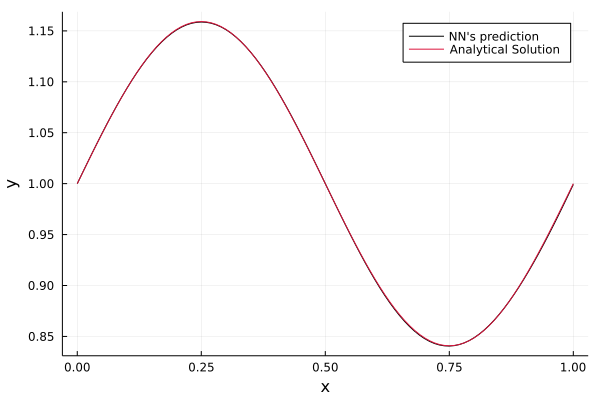

In [11]:
plot(T,Ψ1.(T),color = "black", label="NN's prediction")
plot!(T, F_target1.(T), color = "crimson", label = "Analytical Solution")
xlabel!("x")
ylabel!("y")

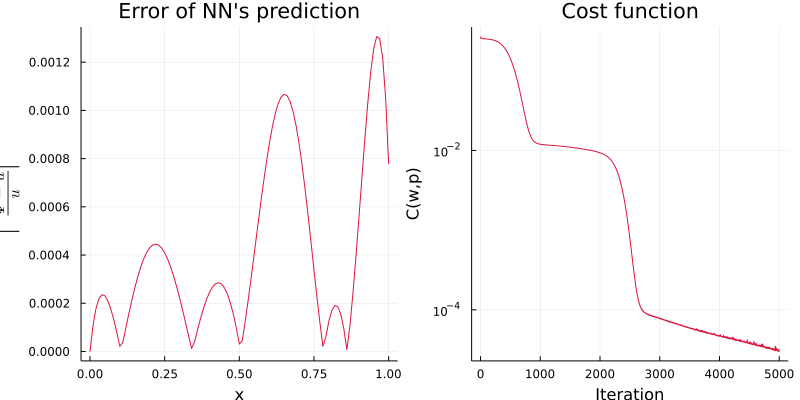

In [12]:
p1 = plot(T,abs.((Ψ1.(T) - F_target1.(T))./F_target1.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="x", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:it, history1, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## Example 2

Let's consider an exponential decay of a physical quantity $u(x)$ represented by the next ODE:

<div id="solve_expdec"></div>
$$
\begin{equation} \label{solve_expdec} \tag{10}
  u'(t) = -\gamma u(t),
\end{equation}
$$

and the initial condition $u(0)=1$ and $t\in[0,1]$. In this example we'll take $\gamma = 2$.

The analytical solution of the IVP in ([10](#solve_expdec)) is

<div id="AnSOl2"></div>
$$
\begin{equation}\label{AnSOL2} \tag{11}
  u(x) = u_0 \exp\left(-\gamma u\right).
\end{equation}
$$

In [13]:
NNODE2 = Chain(x -> [x], # Take in a scalar and transform it into an array
           Dense(1,32,tanh),
           Dense(32,1),first) # Take first value, i.e. return a scalar
NNODE2(1.0)

-0.15806164258906832

In [14]:
Ψ2(t) = Ψ(t; NN=NNODE2, u0 = 10)

Ψ2 (generic function with 1 method)

In [15]:
gamma = 2
loss2() = 0.5*mean(abs2(((Ψ2(t+ϵ)-Ψ2(t-ϵ))/(2*ϵ)) + gamma*Ψ2(t)) for t in T) # Loss function

loss2 (generic function with 1 method)

In [16]:
iter = 0
history2 = zeros(it)
cb2 = function () #callback function to observe training
    global iter += 1
    global history2
    history2[iter]= loss2()
    if iter % 500 == 0
        display(iter)
        display(history2[iter])
    end
end
display(loss2())

194.7422637939453

In [17]:
Flux.train!(loss2, Flux.params(NNODE2), data, opt; cb = cb2)

500

30.126392364501953

1000

16.510164260864258

1500

3.2361981868743896

2000

1.2028555870056152

2500

0.7977799773216248

3000

0.4865688383579254

3500

0.2627638578414917

4000

0.12655754387378693

4500

0.060831084847450256

5000

0.03373615816235542

In [18]:
F_target2(t) = 10*exp(-gamma*t) # Analytical solution

F_target2 (generic function with 1 method)

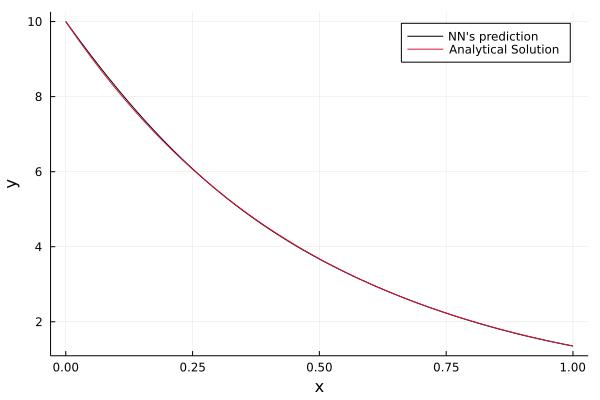

In [19]:
plot(T,Ψ2.(T),color = "black", label="NN's prediction")
plot!(T, F_target2.(T), color = "crimson", label = "Analytical Solution")
xlabel!("x")
ylabel!("y")

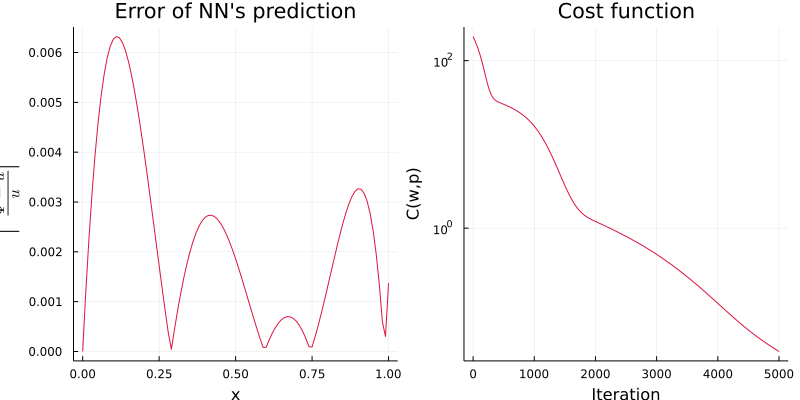

In [20]:
p1 = plot(T,abs.((Ψ2.(T) - F_target2.(T))./F_target2.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="x", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:it, history2, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## Example 3

- ODE: 

<div id="ExamODE3"></div>
$$
\begin{equation} \label{ExamODE3} \tag{11}
  u'(t) + \left(t + \frac{1+3t^2}{1+t+t^3}\right)u= t^3+ 2t + t^2\left(\frac{1+3t^2}{1+t+t^3}\right),
\end{equation}
$$

with $u(0)=1$ and $t \in [0,1]$.

- Analytical solution:

<div id="AnSOL3"></div>
$$
\begin{equation} \label{ANSOL3} \tag{12}
  u(t) = \frac{1}{1+t+t^3}e^{-\frac{t^2}{2}} + t^2.
\end{equation}
$$

In [21]:
NNODE3 = Chain(x -> [x], # Take in a scalar and transform it into an array
           Dense(1,32,tanh),
           Dense(32,1),first) # Take first value, i.e. return a scalar
NNODE2(1.0)

-8.644793889218914

In [22]:
Ψ3(t) = Ψ(t; NN=NNODE3, u0 = 1)

Ψ3 (generic function with 1 method)

In [23]:
loss3() = 0.5*mean(abs2(((Ψ3(t+ϵ)-Ψ3(t-ϵ))/(2*ϵ)) + (t + (1+3*t^2)/(1+t+t^3))*Ψ3(t) - (t^3 + 2*t + t^2*((1+3*t^2)/(1+t+t^3)))) for t in T) # Loss function

loss3 (generic function with 1 method)

In [24]:
iter = 0
history3 = zeros(it)
cb3 = function () #callback function to observe training
    global iter += 1
    global history3
    history3[iter]= loss3()
    if iter % 500 == 0
        display(iter)
        display(history3[iter])
    end
end
display(loss3())

0.21128471195697784

In [25]:
Flux.train!(loss3, Flux.params(NNODE3), data, opt; cb = cb3)

500

0.0013800532324239612

1000

0.0010403719497844577

1500

0.0006503829499706626

2000

0.00023061786487232894

2500

0.0001071355800377205

3000

0.00010001820919569582

3500

9.604656952433288e-5

4000

9.122843766817823e-5

4500

8.560116111766547e-5

5000

7.962958625284955e-5

In [26]:
F_target3(t) = exp(-t^2 / 2)/(1+t+t^3)+t^2 # Analytical solution

F_target3 (generic function with 1 method)

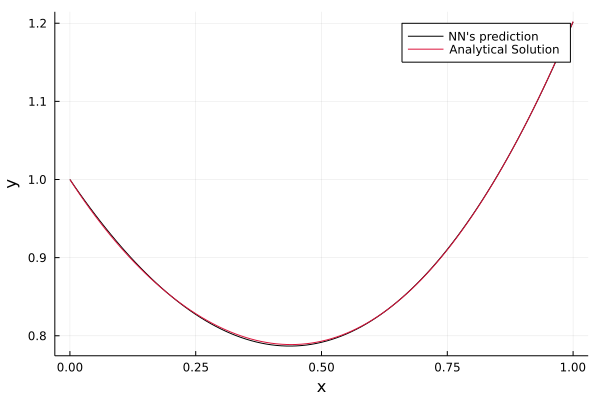

In [27]:
plot(T,Ψ3.(T),color = "black", label="NN's prediction")
plot!(T, F_target3.(T), color = "crimson", label = "Analytical Solution")
xlabel!("x")
ylabel!("y")

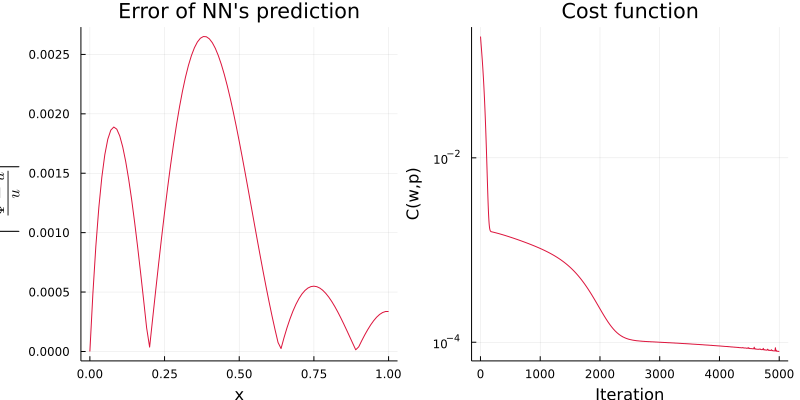

In [28]:
p1 = plot(T,abs.((Ψ3.(T) - F_target3.(T))./F_target3.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="x", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:it, history3, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## Neuman's Boundary Conditions

## Example 1

## Referencias

1. `Lagaris, Isaac & Likas, Aristidis & Fotiadis, Dimitrios. (1998). Artificial neural networks for solving ordinary and partial differential equations. IEEE Transactions on Neural Networks. 9. 987-1000. 10.1109/72.712178.`

2. `Rackauckas, Chris. (2020). Introduction to Scientific Machine Learning through Physics-Informed Neural Networks.`https://book.sciml.ai/course/

3. `Larrañaga, Eduard. (2022). Notes of Physics Informed Neural Networks (PINNs).`